In [1]:
import pandas as pd
import numpy as np
from fancyimpute import SoftImpute
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
import seaborn as sns


%matplotlib inline

Using TensorFlow backend.


# Part 1: Data Exploration and Evaluation

In [2]:
# select columns to load for csv
load_cols = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
df_loans = pd.read_csv('data/loan.csv', usecols = load_cols)
df_loans.shape

(887379, 11)

In [3]:
df_loans.dtypes

loan_amnt      float64
funded_amnt    float64
term            object
int_rate       float64
grade           object
annual_inc     float64
issue_d         object
loan_status     object
dti            float64
revol_bal      float64
total_pymnt    float64
dtype: object

In [4]:
df_loans.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,Current,17.94,27783.0,3242.170000


In [5]:
# check for infinity in any numeric columns
np.isinf(df_loans.select_dtypes(include=[np.number]).values).sum(axis  = 0)

array([0, 0, 0, 0, 0, 0, 0])

## Missing Data
Only column 'annual_inc' has missing values. None of the numeric columns have infinity.
I used softImpute to Impute the missing data. (for the documentation - "Matrix completion by iterative soft thresholding of SVD decompositions.") I have had good experiences with this imputation method in the past. softImpute minimizes the mean absolute error.

## Outliers
For this analysis, although there are outliers in the data, I did not remove, or adjust them. I would like to spend more time with the data before deciding what an outlier for this dataset. 

In [6]:
# check for missing values
pd.isnull(df_loans).sum(axis = 0)

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     4
issue_d        0
loan_status    0
dti            0
revol_bal      0
total_pymnt    0
dtype: int64

In [7]:
index_missing = df_loans[pd.isnull(df_loans).any(axis = 1)].index
df_loans.iloc[index_missing]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.0,0.0,5593.46
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7867.53
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7530.42
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,Does not meet the credit policy. Status:Fully ...,4.0,0.0,7373.83


In [8]:
# one hot encode categorical variables for imputation
df_one_hot = pd.get_dummies(df_loans)

In [9]:
imputed  = SoftImpute().fit_transform(df_one_hot)

[SoftImpute] Max Singular Value of X_init = 96636409.377654
[SoftImpute] Iter 1: observed MAE=44.772655 rank=4
[SoftImpute] Iter 2: observed MAE=44.772655 rank=4
[SoftImpute] Iter 3: observed MAE=44.772655 rank=4
[SoftImpute] Iter 4: observed MAE=44.772655 rank=4
[SoftImpute] Iter 5: observed MAE=44.772655 rank=4
[SoftImpute] Iter 6: observed MAE=44.772655 rank=4
[SoftImpute] Iter 7: observed MAE=44.772655 rank=4
[SoftImpute] Iter 8: observed MAE=44.772655 rank=4
[SoftImpute] Iter 9: observed MAE=44.772654 rank=4
[SoftImpute] Iter 10: observed MAE=44.772654 rank=4
[SoftImpute] Iter 11: observed MAE=44.772654 rank=4
[SoftImpute] Iter 12: observed MAE=44.772654 rank=4
[SoftImpute] Iter 13: observed MAE=44.772654 rank=4
[SoftImpute] Iter 14: observed MAE=44.772654 rank=4
[SoftImpute] Iter 15: observed MAE=44.772654 rank=4
[SoftImpute] Iter 16: observed MAE=44.772654 rank=4
[SoftImpute] Iter 17: observed MAE=44.772654 rank=4
[SoftImpute] Iter 18: observed MAE=44.772654 rank=4
[SoftImpute] 

In [10]:
df_one_hot[df_one_hot.columns] = imputed

In [11]:
df_loans.annual_inc = df_one_hot.annual_inc

In [12]:
#review imputed records
df_loans.iloc[index_missing]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,5594.992255,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.0,0.0,5593.46
42450,7000.0,7000.0,36 months,7.75,A,7839.487615,Aug-2007,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7867.53
42480,6700.0,6700.0,36 months,7.75,A,7503.522304,Jul-2007,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7530.42
42533,6500.0,6500.0,36 months,8.38,A,7291.625253,Jun-2007,Does not meet the credit policy. Status:Fully ...,4.0,0.0,7373.83


## General Data Understanding

In [13]:
pandas_profiling.ProfileReport(df_loans)

Number of variables,11
Number of observations,887379
Total Missing (%),0.0%
Total size in memory,74.5 MiB
Average record size in memory,88.0 B
Numeric,6
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,1


# Part 2: Business Analysis

## 1)

In [14]:
(df_loans.loan_status.value_counts() / len(df_loans.loan_status)) * 100

Current                                                67.815330
Fully Paid                                             23.408600
Charged Off                                             5.099061
Late (31-120 days)                                      1.306206
Issued                                                  0.953369
In Grace Period                                         0.704659
Late (16-30 days)                                       0.265614
Does not meet the credit policy. Status:Fully Paid      0.224031
Default                                                 0.137371
Does not meet the credit policy. Status:Charged Off     0.085758
Name: loan_status, dtype: float64

23.4% loans were fully paid 

Note: an addition 0.22% are marked as "Does not meet the credit policy. Status: Fully Paid" it is not clear if these loans should be included in fully paid.



## 2) 
Note: all loans other than those marked as 'Fully Paid' have been mapped to "Defaulted." This mapping includes the small number of loans marked as "Does not meet the credit policy. Status: Fully Paid"

In [15]:
df_loans.loan_status.values

array(['Fully Paid', 'Charged Off', 'Fully Paid', ..., 'Current',
       'Current', 'Current'], dtype=object)

In [16]:
# map loan status
df_loans['loan_status_mapped'] = ['Defaulted' if x != 'Fully Paid' else x for x in df_loans.loan_status.values]

In [17]:
# split load issues year
df_loans['month'], df_loans['year'] = df_loans['issue_d'].str.split('-').str

In [18]:
df_loans_bucketed = df_loans.groupby(['year', 'grade', 'loan_status_mapped'], as_index  = False).size()

In [19]:
df_loans_bucketed = df_loans_bucketed / df_loans_bucketed.groupby(level=[0, 1]).transform("sum")

In [20]:
df_loans_bucketed.idxmax()

('2007', 'G', 'Defaulted')

Loans from 2007 with grade G have the highed Defaulted rate.

## 3)

In [21]:
df_loans['annualized_rate_of_return'] = (df_loans.total_pymnt / df_loans.funded_amnt) ** (1/3) - 1

In [22]:
pd.DataFrame(df_loans.groupby(['year', 'grade'])['annualized_rate_of_return'].mean().rename("average_annualized_rate_of_return"))

average_annualized_rate_of_return
year grade                                   
2007 A                               0.027138
     B                              -0.001888
     C                              -0.008031
     D                              -0.014353
     E                              -0.015099
     F                              -0.079863
     G                              -0.044102
2008 A                               0.023445
     B                              -0.000428
     C                              -0.004508
     D                              -0.018365
     E                              -0.003337
     F                              -0.045138
     G                              -0.007913
2009 A                               0.021337
     B                               0.014358
     C                               0.011975
     D                               0.013982
     E                              -0.000270
     F                               0.002615
     G                               0.002985
2010 A                               0.022177
     B                               0.022080
     C                               0.022898
     D                               0.016974
     E                               0.023725
     F                               0.024565
     G                               0.020042
2011 A                               0.015049
     B                               0.020336
...                                       ...
     F                               0.014506
     G                               0.005108
2012 A                               0.015106
     B                               0.019565
     C                               0.015836
     D                               0.012208
     E                              -0.000143
     F                              -0.004124
     G                              -0.015510
2013 A                              -0.015742
     B                              -0.011406
     C                              -0.028646
     D                              -0.024081
     E                              -0.041085
     F                              -0.053547
     G                              -0.055009
2014 A                              -0.142876
     B                              -0.137111
     C                              -0.150848
     D                              -0.159592
     E                              -0.165378
     F                              -0.153738
     G                              -0.167700
2015 A                              -0.462427
     B                              -0.476787
     C                              -0.467296
     D                              -0.454088
     E                              -0.457781
     F                              -0.449636
     G                              -0.427172

[63 rows x 1 columns]

# Part 3: Modeling

### Target:
loan_status_mapped - mapped to 'Fully Paid' or 'Defaulted' based on Part 2

### Features excluded:
funded_amnt - The total amount committed to that loan at that point in time.

term - all loans are assumed to be 36 months

issue_d  - assuming that loans are independent of time

total_pymnt - would not yet know how much was paid back

### Features Included:
loan_amnt - would know how much each loan request was for

int_rate - would have interest rate associated with each request

grade - LC assigned loan grade

annual_inc - must report annual income to get loan

revol_bal - Total credit balance would be known before loan

dti - seems to be excluding LC's requested loan, so this value could be known at origination 


In [23]:
df_model = df_loans[['loan_amnt', 'int_rate', 'grade', 'annual_inc', 'revol_bal',  'dti', 'loan_status_mapped']]
df_model['loan_status_one_hot'] = df_model.loan_status_mapped.map({'Fully Paid': 1, 'Defaulted': 0})
df_model.drop(columns = 'loan_status_mapped',  inplace = True)
df_model = pd.get_dummies(df_model)
df_model_y = df_model['loan_status_one_hot']
df_model.drop(columns = 'loan_status_one_hot',  inplace = True)

X = Normalizer().fit_transform(df_model)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, df_model_y, test_size=0.3, random_state=1234)

In [25]:
clf_lr_balanced_l2 = LogisticRegressionCV(cv=5, random_state=12354, n_jobs= -1, class_weight = 'balanced', penalty= 'l2', scoring= metrics.make_scorer(f1_score)).fit(X_train, y_train)

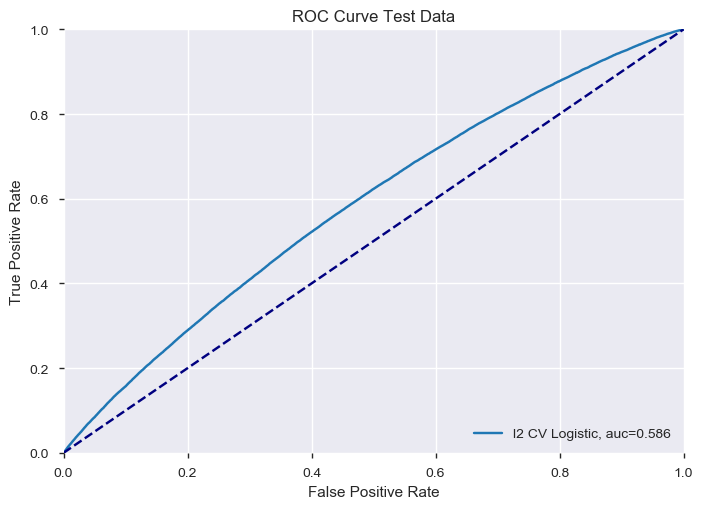

In [26]:
y_pred_proba = clf_lr_balanced_l2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="l2 CV Logistic, auc="+str(round(auc,3)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve Test Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

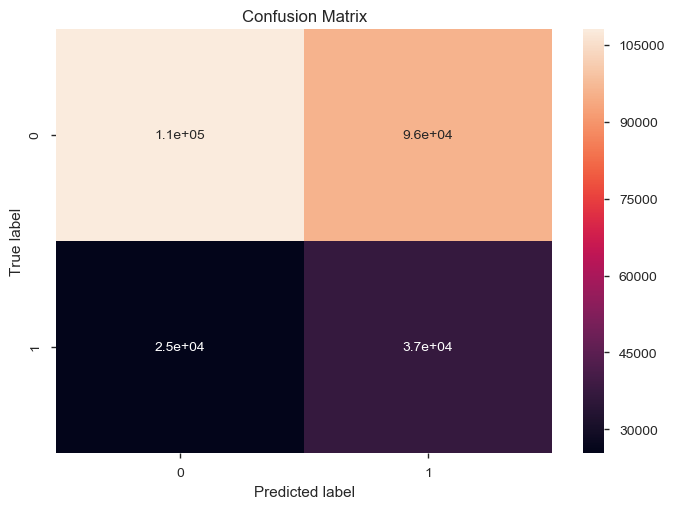

In [27]:
y_pred = clf_lr_balanced_l2.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

I trained my model based on accuracy with 5-fold cross-validation and used l2 regularization. At all thresholds on the ROC curve, the logistic regression was better than random, but not by much; the AUC is just over .5. 

I would not consider my model to be particularly useful. Some of my model's ineffectiveness is due to my mapping of labels from part 2  (all loans other than 'Fully Paid' were marked as 'Defaulted').  I would next explore other model families to see if different families of classifiers perform better. I would like to see if SVM's (particularly with non-linear kernels) or tree-based models would perform better.